### Gradient Descent and FISTA

$\newcommand\measurementvec{\mathbf{b}}
\newcommand\measurementmtx{\mathbf{A}}
\newcommand\imagevec{\mathbf{v}}
\newcommand\psf{\mathbf{h}}
\newcommand{\crop}{\mathbf{C}}
\newcommand\full{\mathbf{A}}
\newcommand{\ftpsf}{\mathbf{H}}$
Gradient descent is an iterative algorithm that finds the minimum of a convex function by following the slope "downhill" until it reaches a minimum. To solve the minimization problem
\begin{equation*}
    \operatorname{minimize} g(\mathbf{x}),
\end{equation*}
we find the gradient of $g$ wrt $\mathbf{x}$, $\nabla_\mathbf{x} g$, and use the property that the gradient always points in the direction of steepest _ascent_. In order to minimize $g$, we go the other direction:
$$\begin{align*}
    \mathbf{x}_0 &= \text{ initial guess} \\
    \mathbf{x}_{k+1} &\leftarrow \mathbf{x}_k - \alpha_k \nabla g(\mathbf{x}_k),
\end{align*}$$
where $\alpha$ is a step size that determines how far in the descent direction we go at each iteration.

Applied to our problem:
$$\begin{align*}
    g(\imagevec) &= \frac{1}{2} \|\full\imagevec- \measurementvec \|_2^2 \\
    \nabla_\imagevec g(\imagevec) &= \full^H (\full\imagevec-\measurementvec),
\end{align*}$$
where $\full^H$ is the adjoint of $\full$, $\measurementvec$ is the sensor measurement and $\imagevec$ is the image of the scene.

We use more efficient variants of this algorithm, like Nesterov Momentum and FISTA, both of which are shown below. 



#### Loading and preparing our images

In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import cv2
%matplotlib inline

The code takes in two grayscale images: a point spread function (PSF) $\texttt{psfname}$ and a sensor measurement $\texttt{imgname}$. The images can be downsampled by a factor $f$, which must be a of the form $1/{2^k}$, for some non negative integer $k$ (typically between 1/2 and 1/8). 

In [74]:
psfname = './psf_6.jpg'
imgname = './chameleon.jpg'

# Downsampling factor (used to shrink images)
f = 1/4 

# Number of iterations
iters = 100

In [41]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def loaddata_hls(show_im=True):
#     psf = cv2.imread(psfname)
#     psf = cv2.cvtColor(psf, cv2.COLOR_BGR2GRAY)
    psf = Image.open(psfname).convert('RGB')
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname).convert('RGB')
    data = np.array(data, dtype='float32')

    
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(0.114*psf[5:15,5:15,0]+0.587*psf[5:15,5:15,1]+0.2989*psf[5:15,5:15,2]) 
    bg = (bg-127.5)/127.5
    print('max:',np.max(psf),'  min:',np.min(psf))
    print('bg:',bg)

    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img
    
    print('[0][0][0]=',data[0,0,0],'[0][0][1]=',data[0,0,1],'[0][0][2]=',data[0,0,2])
    psf = resize(psf, f)
    data = resize(data, f)

    print('[0][0][0]=',data[0,0,0],'[0][0][1]=',data[0,0,1],'[0][0][2]=',data[0,0,2])
    
    psf = (psf-127.5)/127.5
    data = (data-127.5)/127.5
    print(psf.shape,psf.dtype)
    print(data.shape,psf.dtype)    
    psf = 0.114*psf[:,:,0]+ 0.587*psf[:,:,1]+0.2989*psf[:,:,2]
    data = 0.114*data[:,:,0]+ 0.587*data[:,:,1]+0.2989*data[:,:,2]
    
    psf -= bg
    data -= bg
    print('data[0][0]=',data[0,0])
    print("max(data):",np.max(data))
    print("data[52][0:4]",data[52,31:38])
    
    print(np.linalg.norm(psf.ravel()))
    psf /= np.linalg.norm(psf.ravel())

    print(np.linalg.norm(data.ravel()))
    data /= np.linalg.norm(data.ravel())

    print('data[0][0]=',data[0,0])
    print("max(data):",np.max(data))
    print("data[52][0:4]",data[52,31:38])
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')

        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')

    return psf, data

max: 246.0   min: 0.0
bg: -0.9658619637582816
[0][0][0]= 15.0 [0][0][1]= 21.0 [0][0][2]= 17.0
[0][0][0]= 15.0 [0][0][1]= 21.0 [0][0][2]= 19.0
(120, 160, 3) float32
(120, 160, 3) float32
data[0][0]= 0.12059802
max(data): 1.9155662
data[52][0:4] [1.0610882 1.0980403 1.1294098 1.1588187 1.1862669 1.2170413 1.2484107]
37.20637
141.88469
data[0][0]= 0.000849972
max(data): 0.0135008665
data[52][0:4] [0.00747852 0.00773896 0.00796005 0.00816733 0.00836078 0.00857768
 0.00879877]
data: (120, 160) float32
uint8 (480, 640, 3)
(3, 480, 640)
15 21 24
15
21
24


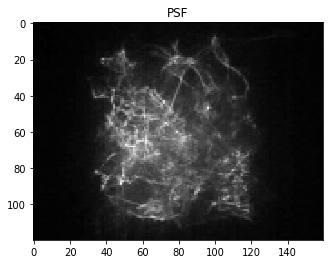

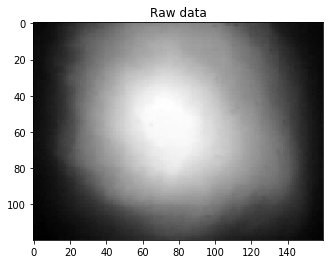

In [76]:
import sys

psf, data = loaddata_hls()
data = data.astype(np.float32)
print('data:',data.shape,data.dtype)
fp = open("img_float.bin",'wb')
fp.write(data)
fp.close()

img = Image.open(imgname).convert('RGB')
img = np.array(img)
print(img.dtype,img.shape)
img = np.transpose(img, (2, 0, 1))
print(img.shape)

print(img[0,0,20],img[1,1,1],img[2,5,4])
bin_img = img.reshape(-1)
print(bin_img[640*480*0+(0*640+20)])
print(bin_img[640*480*1+(1*640+1)])
print(bin_img[640*480*2+(5*640+4)]) #This segment tests the seqence of binfile

b = bin_img.tostring()
fp = open("rgb.bin",'wb')
fp.write(b)
fp.close()

### Calculating convolutions using $\texttt{fft}$
We want to calculate convolutions efficiently. To do this, we use the "fast fourier transform" $\texttt{fft2}$ which computes the Discrete Fourier Transform (DFT). The convolution theorem for DFTs only holds for circular convolutions. We can still recover a linear convolution by first padding the input images then cropping the output of the inverse DFT:
\begin{equation}
h*x=\mathcal{F}^{-1}[\mathcal{F}[h]\cdot\mathcal{F}[x]] = \texttt{crop}\left[\ \texttt{DFT}^{-1}\left\{\ \texttt{DFT} [\ \texttt{pad}[h]\ ]\cdot\texttt{DFT}[\ \texttt{pad}[x]\ ]\ \right\} \ \right]
\end{equation}

Recovering the linear convolution correctly requires that we double the dimensions of our images. To take full advantage of the speed of the $\texttt{fft2}$ algorithm, we actually pad $\texttt{full_size}$, which is the nearest power of two that is larger than that size.

We have chosen $\texttt{full_size}$ in such a way that it provides enough padding to make circular and linear convolutions look the same <i>after being cropped back down to</i> $\texttt{sensor_size}$. That way, the "sensor crop" due to the sensor's finite size and the "fft crop" above are the same, and we just need one crop function.

Along with initialization, we compute $\texttt{H} = \texttt{fft2}(\texttt{hpad})$ and $\texttt{Hadj} = \texttt{H}^*$, which are constant matrices that will be needed to calculate the action of $\measurementmtx$ and $\measurementmtx^H$ at every iteration. 

Lastly, we must take into account one more practical difference. In imaging, we often treat the center of the image as the origin of the coordinate system. This is theoretically convenient, but fft algorithms assume the origin of the image is the top left pixel. The magnitude of the fft doesn't change because of this distinction, but the phase does, since it is sensitive to shifts in real space. An example with the simplest function, a delta function, is displayed below. In order to correct this problem, we use $\texttt{ifftshift}$ to move the origin of an image to the top left corner and $\texttt{fftshift}$ to move the origin from the top left corner to the center. 

For this notebook and the ADMM notebook, we follow the following convention so we don't have to worry about this issue again:
1. All images in _real_ space are stored with the origin in the center (so they can be displayed correctly)
2. All images in _Fourier_ space are stored with the origin in the top left corner (so they can be used for processing correctly)
3. The above rules mean that, to perform a convolution between two real space images $h$ and $x$, we do $$\texttt{fftshift}( \texttt{ifft} [\texttt{fft}[ \texttt{ifftshift}(h) \cdot \texttt{ifftshift}(x) ] ] )$$ instead of $$\texttt{ifft}[\texttt{fft}[h \cdot x]]$$
The rules imply that if we store the fourier transform of $h$ for future use, instead of storing $\texttt{fft}[h]$, we store $\texttt{fft}[\texttt{ifftshift}(h)]$.

In [77]:
def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start
    print('pixel_strat=',pixel_start)

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    print(starti,endi,startj,endj)
    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

#### Computing the gradient

The most important step in Gradient Descent is calculating the gradient
$$ \nabla_\imagevec \  g(\imagevec) = \full^H (\full\imagevec-\measurementvec)$$
We do this in 2 steps:
1. We compute the action of $\full$ on $\imagevec$, using $\texttt{calcA}$
2. We compute the action of $\full^H$ on $\texttt{diff} = \texttt{Av-b}$ using $\texttt{calcAHerm}$ <br/>

Here, $\texttt{vk}$ is the current padded estimate of the scene and $\texttt{b}$ is the sensor measurement.


In [78]:
def grad(Hadj, H, vk, b, crop, pad):
    print("**********************VK TEST 120*****0*********************",file=fft_log)
    print("max:",np.max(vk)," min:",np.min(vk),file=fft_log)
    print("vk_mid[%d][%d]="%(120,20),vk[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),vk[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),vk[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),vk[120,492],file = fft_log)
    
    Av = calcA(H, vk, crop)
    
    diff = Av - b
    
    calcAH = calcAHerm(Hadj, diff, pad)
    print("**********************VK TEST 120*****6*********************",file=fft_log)
    print("max:",np.max(calcAH),"min:",np.min(calcAH),file=fft_log)
    print("vk_mid[%d][%d]="%(120,20),calcAH[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),calcAH[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),calcAH[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),calcAH[120,492],file = fft_log)
    return np.real(calcAH)

We write $\full$ as:
$$ \full\imagevec \iff \mathrm{crop} \left[ \mathcal{F}^{-1} \left\{\mathcal{F}(h) \cdot \mathcal{F}(v)\right\} \right]$$
In code, this becomes
\begin{align*} 
\texttt{calcA}(\texttt{vk}) & = \texttt{crop}\ (\texttt{ifft}\ (\texttt{fft}(\texttt{hpad}) \cdot \texttt{fft}(\texttt{vk})\ )\  )\\
& = \texttt{crop}\ (\texttt{ifft}\ (\texttt{H} \cdot \texttt{Vk}))
\end{align*}
where $\cdot$ represents point-wise multiplication

In [79]:
def calcA(H, vk, crop):
    print("vk:max:",np.max(vk),"min:",np.min(vk),file=fft_log)
    Vk = fft.fft2(fft.ifftshift(vk))
    print("**********************VK TEST 120*****(0.5)*********************",file=fft_log)
    print("max:",np.max(Vk),"min:",np.min(Vk),file=fft_log)
#     print("argmax:",np.argmax(Vk),"argmin:",np.argmin(Vk),file=fft_log)
    print("Vk[0,0]=",Vk[0,0],Vk[9,96],file = fft_log)
    print("vk_mid[%d][%d]="%(120,20),Vk[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),Vk[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),Vk[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),Vk[120,492],file = fft_log)

    vk_mid = H*Vk
    print("**********************VK TEST 120*****1*********************",file=fft_log)
    print("max:",np.max(vk_mid),"min:",np.min(vk_mid),file = fft_log)
    print("argmax:",np.argmax(vk_mid),"argmin:",np.argmin(vk_mid),file=fft_log)
    print("vk_mid[0,0]=",vk_mid[0,0],"H[0,0]=",H[0,0],file = fft_log)
    print("vk_mid[%d][%d]="%(120,20),vk_mid[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),vk_mid[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),vk_mid[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),vk_mid[120,492],file = fft_log)
    
    vk_mid = fft.fftshift(fft.ifft2(vk_mid))
    print("**********************VK TEST 120*****2*********************",file=fft_log)
    print("max:",np.max(vk_mid),"min:",np.min(vk_mid),file=fft_log)
    print("argmax:",np.argmax(vk_mid)," argmin:",np.argmin(vk_mid),file=fft_log)
    print("vk_mid[%d][%d]="%(120,20),vk_mid[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),vk_mid[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),vk_mid[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),vk_mid[120,492],file = fft_log)
    return crop(vk_mid)

We first pad $\texttt{diff}$ , giving us $\texttt{xpad}$, then we take the 2D fourier transform, $\texttt{X} = \mathcal{F}(\texttt{xpad})$. The action of the adjoint of $A$ is

$$ A^H \mathbf{x} \iff \mathcal{F}^{-1} \left\{ \mathcal{F}(\psf)^* \cdot \mathcal{F}( \operatorname{pad}\left[x\right]) \right\}$$
This becomes
\begin{align*}
\texttt{calcAHerm}(\texttt{xk}) &= \texttt{ifft}\ (\ (\texttt{fft}(\texttt{h}))^H \cdot \texttt{fft}\ (\texttt{pad}(\texttt{diff}))\ ) \\
& = \texttt{ifft}\ (\texttt{Hadj} \cdot \texttt{X})
\end{align*}

In [80]:
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    print("**********************VK TEST 120*****3*********************",file=fft_log)
    print("max:",np.max(xpad)," min:",np.min(xpad),file = fft_log)
    print("vk_mid[%d][%d]="%(120,20),xpad[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),xpad[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),xpad[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),xpad[120,492],file = fft_log)
    
    X = fft.fft2(fft.ifftshift(xpad))
    print("**********************VK TEST 120*****4*********************",file=fft_log)
    print("max:", np.max(X)," min:",np.min(X),file=fft_log)
    print("vk_mid[%d][%d]="%(120,20),X[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),X[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),X[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),X[120,492],file = fft_log)
    
    vk_mid = Hadj*X
    print("**********************VK TEST 120*****5*********************",file=fft_log)
    print("max:",np.max(X)," min:",np.min(vk_mid),file = fft_log)
    print("vk_mid[%d][%d]="%(120,20),vk_mid[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),vk_mid[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),vk_mid[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),vk_mid[120,492],file = fft_log)
    
    return fft.fftshift(fft.ifft2(vk_mid))

#### Putting it all together

This is the main function, which calculates the gradients and updates our estimation of the scene:
\begin{align*}
    &\imagevec_0 = \text{ anything} \\
    &\text{for } k = 0 \text{ to num_iters:}\\
    &\quad \quad \imagevec_{k+1} \leftarrow \texttt{gradient_update}(\imagevec_k) \\
\end{align*} 

There are different ways of doing the gradient update. The three we will show are regular GD, Nesterov momentum update, and FISTA.

To guarantee convergence, we set the step size to be 
\begin{align*} 
\alpha_k &< \frac{2}{\|\measurementmtx^H \measurementmtx\|}_2 \approx \frac{2}{\lambda_{max}(\mathbf{M}^H\mathbf{M})}
\end{align*}

To calculate this, we use the property that $\mathbf{M}$ is diagonalizable by a Fourier Transform:
$$\begin{align*}
\mathbf{M}^H\mathbf{M} &= \left(\mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F}\right)^H \ \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
&= \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \\
\lambda_{max}(\mathbf{M}^H\mathbf{M}) &= \max \left(\mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \right)
\end{align*}$$
In code, we have
\begin{align*}
\alpha = \frac{1.8}{\texttt{max} \left(\texttt{Hadj} \cdot \texttt{H}\right)}
\end{align*}


Since we are dealing with images, one constraint on the reconstructed image $\imagevec_k$ is that all the entries have to be non-negative. We do this by doing projected gradient descent. The projection function $\texttt{proj}$ we use is non-negativity, which  projects $\texttt{vk}$ onto the non-negative halfspace.  

In [81]:
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(on_alpha/(np.max(Hadj * H)))
    iterations = 0
    print('alpha=',alpha," alpha/2=",alpha/2)
    def non_neg(xi): #ReLU
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.

    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    print(vk.shape)
    
    print("***************b******************",file=fft_log)
    print("max:",np.max(b)," min:",np.min(b),file = fft_log)
    print("b[52,20]",b[52,20],file=fft_log)
    print("b[52,40]",b[52,40],file=fft_log)
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
    print('vk before:',file = log_file)
    print(vk[120:123,245:248],file = log_file)
    print('xk before:',file = log_file)
    print(xk[120:123,245:248],file = log_file)
    print('tk before: ',tk,file = log_file)
    for iterations in range(iter_hls):      
        print('****************iteration=',iterations,'************',file = log_file)
        # uncomment for FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)
        
        print('vk after:',file = log_file)
        print(vk[120:123,245:248],file = log_file)
        print('xk after:',file = log_file)
        print(xk[120:123,245:248],file = log_file)
        print('tk after: ',tk,file = log_file)
        if iterations % 5 == 0:
            image = proj(crop(vk))
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(iterations))
            display.display(f)
            display.clear_output(wait=True)

    image = proj(crop(vk))
    f = plt.figure(1)
    plt.imshow(image, cmap='gray')
    plt.title('Reconstruction after iteration {}'.format(iterations))

    print('vk.dtype in gd:',vk.dtype)
    return crop(vk),vk
    

#### Gradient descent algorithms

##### Regular Gradient Descent
Regular gradient descent is simply following the negative of the gradient until we reach the minimum:

\begin{align*}
    & \texttt{gradient_update}(\imagevec_k): \\
    &\quad \quad\imagevec'_{k+1} \leftarrow \imagevec_k - \alpha_k \full^H(\full\imagevec_k - \measurementvec) \\
    &\quad \quad \imagevec_{k+1} \leftarrow \operatorname{proj}_{\imagevec \geq 0} (\imagevec_{k+1}')
\end{align*} 

##### Nesterov Momentum
GD works but it's slow. One way to speed it up is to consider a velocity term, $\mathbf{p}$. Each update becomes:

\begin{align*}
    &\texttt{gradient_update}(\imagevec_k): \\
    &\qquad \mathbf{p}_{k+1} \leftarrow \mu \mathbf{p}_k - \alpha_k \texttt{grad}(\imagevec_k) \\
    &\qquad \imagevec_{k+1}' \leftarrow \imagevec_k - \mu \mathbf{p}_{k} + (1+\mu)\mathbf{p}_{k+1} \\
    &\qquad \imagevec_{k+1} \leftarrow \operatorname{proj}_{\imagevec \geq 0} (\imagevec_{k+1}')
\end{align*}

The parameter $\mu$ is called the momentum and is strictly between 0 and 1.

##### FISTA 
Instead of Nesterov momentum, we can use FISTA, which speeds up the iterative process. Each iteration of the algorithm is as follows:

\begin{align*}
    &\texttt{gradient_update}(\imagevec_k):\\
    &\qquad \imagevec_k \leftarrow \imagevec_k - \alpha_k \texttt{grad}(\imagevec_k) \\ 
    &\qquad x_{k} \leftarrow \texttt{proj}(\imagevec_k) \\
    &\qquad t_{k+1} \leftarrow \frac{1+\sqrt{1+4t_k^2}}{2} \\
    &\qquad \imagevec_{k+1} \leftarrow x_{k} + \frac{t_k-1}{t_{k+1}} (x_{k}-x_{k-1}) \\
\end{align*}


In [82]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
#     print("vk.dtype in fista_update:",vk.dtype)
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    
#     print("b TEST:max:",np.max(b)," min:",np.min(b)," mean:",np.mean(b))
    print("**********************VK TEST 120*****7*********************",file=fft_log)
    print("max: ",np.max(vk)," min:",np.min(vk),file = fft_log)
    print("vk_mid[%d][%d]="%(120,20),vk[120,20],file = fft_log)
    print("vk_mid[%d][%d]="%(120,196),vk[120,196],file = fft_log)
    print("vk_mid[%d][%d]="%(120,216),vk[120,216],file = fft_log)
    print("vk_mid[%d][%d]="%(120,492),vk[120,492],file = fft_log)
    
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk

#### Running the algorithm

max: 246.0   min: 0.0
bg: -0.9658619637582816
[0][0][0]= 15.0 [0][0][1]= 21.0 [0][0][2]= 17.0
[0][0][0]= 15.0 [0][0][1]= 21.0 [0][0][2]= 19.0
(120, 160, 3) float32
(120, 160, 3) float32
data[0][0]= 0.12059802
max(data): 1.9155662
data[52][0:4] [1.0610882 1.0980403 1.1294098 1.1588187 1.1862669 1.2170413 1.2484107]
37.20637
141.88469
data[0][0]= 0.000849972
max(data): 0.0135008665
data[52][0:4] [0.00747852 0.00773896 0.00796005 0.00816733 0.00836078 0.00857768
 0.00879877]


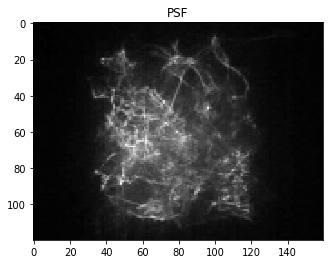

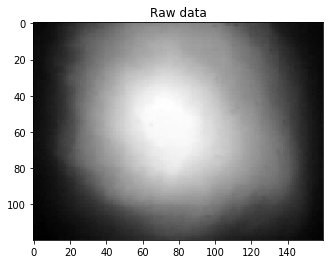

In [83]:
psf, data = loaddata_hls()

vk.dtype in gd: float32


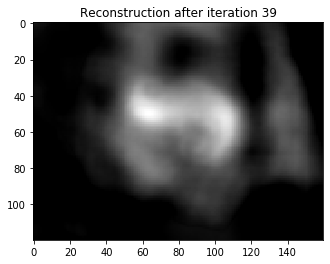

In [84]:
fft_log = open('fft_log.txt','w',encoding="utf-8")
log_file = open('iter_log.txt','w',encoding="utf-8")
iter_hls = 40
on_alpha = 1.8 
res_120,vk_256 = grad_descent(psf, data)#run gd
fft_log.close()
log_file.close()

## Tools for viewing result of hls-resconstruction

In [85]:
hls_res = np.fromfile('result_40_1.bin',dtype=np.float32)
print(hls_res.shape)
hls_res = hls_res.reshape((120,160))
print(hls_res.shape)
print(hls_res[120-68:123-68,245-176:248-176])

def proj2(xi): #ReLU
    xi = np.maximum(xi,0)
    return xi
hls_img = proj2(hls_res)

(19200,)
(120, 160)
[[0.15998285 0.15580976 0.15126182]
 [0.15244296 0.14888714 0.14428703]
 [0.14327605 0.14018266 0.13615209]]


max in py= 0.1620094  min in py= -0.001399658
mean in py= 0.028199071 std var in py= 0.03428373
max in hls= 0.21266899  min in py= 0.0
mean in hls= 0.035833824 std var in hls= 0.0419834


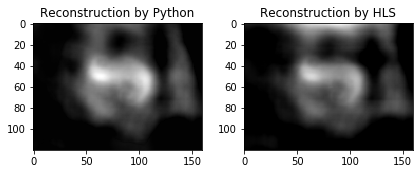

In [86]:
from scipy import signal

fig,ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].imshow(res_120,cmap='gray')
ax[0].set_title('Reconstruction by Python')
ax[1].imshow(hls_img, cmap='gray')
ax[1].set_title('Reconstruction by HLS')

print("max in py=",np.max(res_120)," min in py=",np.min(res_120))
print("mean in py=",np.mean(res_120),"std var in py=",np.std(res_120))

print("max in hls=",np.max(hls_img)," min in py=",np.min(hls_img))
print("mean in hls=",np.mean(hls_img),"std var in hls=",np.std(hls_img))



## Tools for generate bin file of H and Vk

In [87]:
H, Hadj, v, utils = initMatrices(psf)
crop = utils[0]
pad = utils[1]

print(H.dtype,H.shape)
H_list = []
H_2_hls = np.empty((2,256,512))
print(H_2_hls.shape)
H_2_hls[0,:,:]=H.real
H_2_hls[1,:,:]=H.imag
H_2_hls = np.transpose(H_2_hls, (1,2,0))
print(H_2_hls.shape)

pixel_strat= 0.018086044117808342
68 188 176 336
complex128 (256, 512)
(2, 256, 512)
(256, 512, 2)


In [88]:
H_2_hls = H_2_hls.reshape(-1)
H_2_hls = H_2_hls.astype(np.float32)
H_list.extend(H_2_hls.tolist())  
import struct
fp = open("H_psf_divnorm_trans.bin",'wb')
s = struct.pack('f'*len(H_2_hls), *H_2_hls)
fp.write(s)
fp.close()
#####################################
vk_list = [] #vk's shape=(256,512)
vk_2_hls = vk_256
print('vk_2_hls:',vk_2_hls.dtype,vk_2_hls.shape)
print(vk_2_hls[0][0],vk_2_hls[128][335],vk_2_hls[128][336])
vk_2_hls = vk_2_hls.reshape(-1)
vk_list.extend(vk_2_hls.tolist())  
fp = open("vk_iter.bin",'wb')
s = struct.pack('f'*len(vk_2_hls), *vk_2_hls)
fp.write(s)
fp.close()
print('bin generated')

vk_2_hls: float32 (256, 512)
7.8390263e-19 0.0 0.0
bin generated


(120, 160)


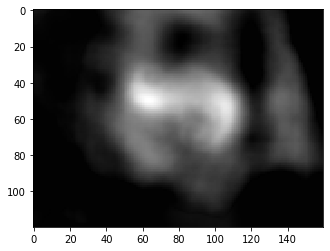

In [89]:
print(res_120.shape)
f = plt.figure(1)
plt.imshow(res_120, cmap='gray')
plt.imsave('./res_gray.jpg',res_120,cmap = 'gray')